<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/ml_Solutions/nvidia/TAO/TAO_multitask_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nvidia TAO (Train, Adapt and  Optimize)

NVIDIA TAO is a low-code AI toolkit built on TensorFlow and PyTorch, which simplifies and accelerates the model training process by abstracting away the complexity of AI models and the deep learning framework. With TAO, users can select one of 100+ pre-trained vision AI models from NGC and fine-tune and customize on their own dataset without writing a single line of code. The output of TAO is a trained model in ONNX format that can be deployed on any platform that supports ONNX.

## LINKS
- https://docs.nvidia.com/tao/tao-toolkit/text/overview.html#tab-0-0-0
- https://docs.nvidia.com/tao/tao-toolkit/text/quick_start_guide/index.html#requirements
- https://github.com/NVIDIA-AI-IOT/nvidia-tao
- https://docs.nvidia.com/tao/tao-toolkit/text/working_with_the_containers.html#invoking-the-containers-directly
- https://docs.nvidia.com/tao/tao-toolkit/text/running_in_cloud/overview.html
- https://developer.nvidia.com/tao-toolkit-get-started
- https://developer.nvidia.com/tao-toolkit
- https://docs.ngc.nvidia.com/cli/cmd.html
- https://catalog.ngc.nvidia.com/models?filters=&orderBy=weightPopularDESC&query=&page=&pageSize=
- https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small?resource=download
- https://developer.nvidia.com/nvidia-tensorrt-8x-download



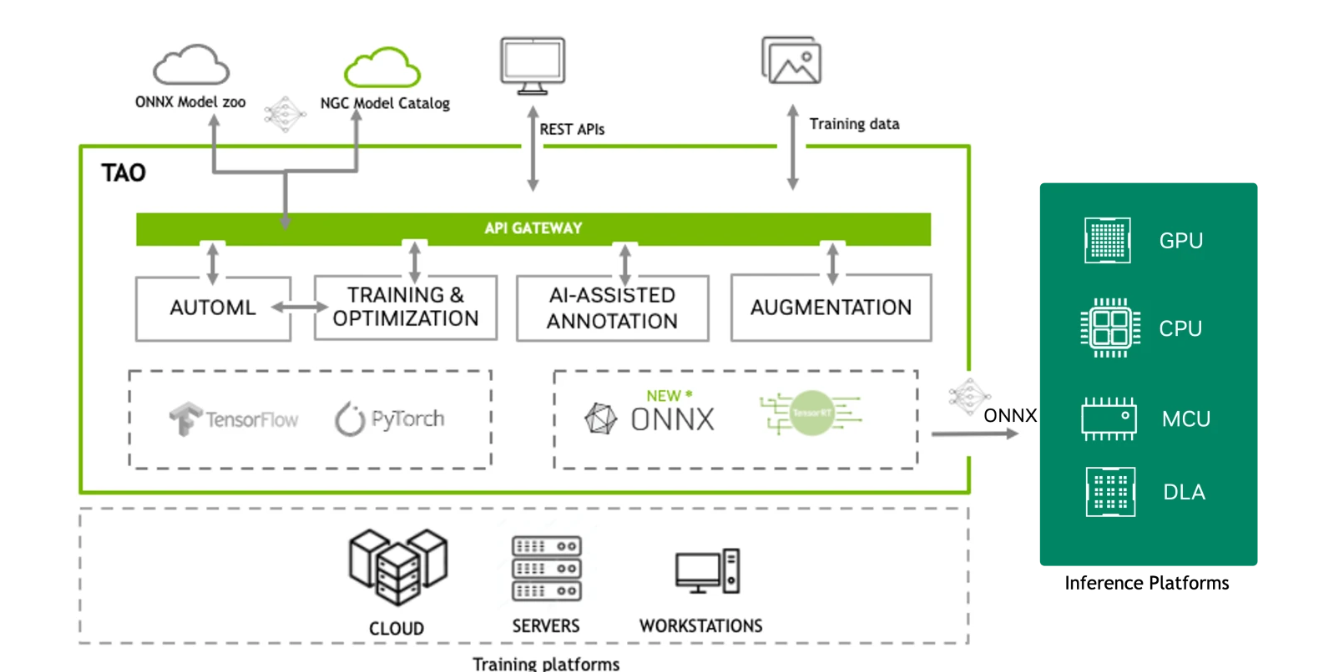

## Get the TensorRT tar file before running this Notebook

1. Visit https://developer.nvidia.com/tensorrt
2. Clicking `Download now` from step one directs you to https://developer.nvidia.com/nvidia-tensorrt-download where you have to Login/Join Now for Nvidia Developer Program Membership
3. Now, in the download page: Choose TensorRT 8 in available versions
4. Agree to Terms and Conditions
5. Click on TensorRT 8.6 GA to expand the available options
6. Click on 'TensorRT 8.6 GA for Linux x86_64 and CUDA 12.0 and 12.1 TAR Package' to dowload the TAR file
7. Upload the the tar file to your Google Drive

## Mounting Google drive
Mount your Google drive storage to this Colab instance

In [ ]:
import sys
if 'google.colab' in sys.modules:
    %env GOOGLE_COLAB=1
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
else:
    %env GOOGLE_COLAB=0
    print("Warning: Not a Colab Environment")

## Multi-task classification using TAO

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task.

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/TAO/tlt-tao-toolkit-bring-your-own-model-diagram.png" width="1080">



### Table of Contents
This notebook shows an example use case for classification using the Train Adapt Optimize (TAO) Toolkit.

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1) <br>
     1.1 [Download the dataset](#head-1-1)<br>
     1.2 [Verify the downloaded dataset](#head-1-2)<br>
     1.3 [Data preprocessing](#head-1-3)<br>
     1.4 [Download pretrained model](#head-1-4)
2. [Setup GPU environment](#head-2) <br>
    2.1 [Setup Python environment](#head-2-1) <br>
3. [Provide training specification](#head-3)
4. [Run TAO training](#head-4)
5. [Evaluate trained models](#head-5)
6. [Prune trained models](#head-6)
7. [Retrain pruned models](#head-7)
8. [Testing the model](#head-8)
9. [Inferences](#head-9)

## 0. Set up env variables  <a class="anchor" id="head-0"></a>

https://github.com/NVIDIA-AI-IOT/nvidia-tao

### Requirements
https://docs.nvidia.com/tao/tao-toolkit/text/quick_start_guide/index.html#requirements



In [ ]:
# Setting up env variables for cleaner command line commands.
import os

%env TAO_DOCKER_DISABLE=1

%env KEY="KEY"

#Number of GPU,s
%env NUM_GPUS=1


#colab Path
%env COLAB_NOTEBOOKS_PATH=/content/drive/MyDrive/repos/nvidia-tao
# if os.environ["GOOGLE_COLAB"] == "1":
#     if not os.path.exists(os.path.join(os.environ["COLAB_NOTEBOOKS_PATH"])):

#       !git clone https://github.com/NVIDIA-AI-IOT/nvidia-tao.git $COLAB_NOTEBOOKS_PATH
# else:
#     if not os.path.exists(os.environ["COLAB_NOTEBOOKS_PATH"]):
#         raise Exception("Error, enter the path of the colab notebooks repo correctly")

# Expeiment Dir
%env EXPERIMENT_DIR=/content/drive/MyDrive/results/multitask_classification
# Delete Experiments
delete_existing_experiments = True
# Data Dir
%env DATA_DIR=/content/drive/MyDrive/data/multitask_classification_data
# Delete or Not Data
delete_existing_data = False

if delete_existing_experiments:
    !sudo rm -rf $EXPERIMENT_DIR
if delete_existing_data:
    !sudo rm -rf $DATA_DIR

SPECS_DIR=f"{os.environ['COLAB_NOTEBOOKS_PATH']}/tensorflow/multitask_classification/specs"
%env SPECS_DIR={SPECS_DIR}
# Showing list of specification files.
!ls -rlt $SPECS_DIR

!sudo mkdir -p $DATA_DIR && sudo chmod -R 777 $DATA_DIR
!sudo mkdir -p $EXPERIMENT_DIR && sudo chmod -R 777 $EXPERIMENT_DIR

## 1. Prepare datasets and pre-trained model <a class="anchor" id="head-1"></a>

We will be using the Fashion Product Images (Small) for the tutorial. This dataset is available on Kaggle.

In this tutorial, our trained classification network will perform three tasks: article category classification, base color classification and target season classification.

### 1.1 Download the dataset <a class="anchor" id="head-1-1"></a>

To download the dataset, you will need a Kaggle account. After login, you can download the dataset zip file here: https://www.kaggle.com/paramaggarwal/fashion-product-images-small

The downloaded file is `archive.zip` with a subfolder called `myntradataset`. Unzip contents in this subfolder to your `DATA_DIR` created in the cell above and you should have a folder called `images` and a CSV file called `styles.csv`

### 1.2 Verify the downloaded dataset <a class="anchor" id="head-1-2"></a>

In [ ]:
!ls $DATA_DIR/archive.zip
if os.path.exists(os.environ["DATA_DIR"]):
  !unzip -q $DATA_DIR/archive.zip -d $DATA_DIR/
else:
  raise Exception("Place archive.zip in $DATA_DIR folder")

In [ ]:
# Check the dataset is present
!if [ ! -d $DATA_DIR/images ]; then echo 'images folder NOT found.'; else echo 'Found images folder.';fi
!if [ ! -f $DATA_DIR/styles.csv ]; then echo 'CSV file NOT found.'; else echo 'Found CSV file.';fi

### 1.3 Data preprocessing <a class="anchor" id="head-1-3"></a>

In order to make data trainable in TAO, we need to preprocess it and do train / val split.

TAO Multitask classification requires:   
1. A training label CSV file containing labels for training images
2. A validation label CSV file containing labels for validation images
3. An image folder containing all train and val images (may also contain other images, the images to be used is controlled by CSV files).

The CSV files for training / validation labels should have following patterns:
1. The first column should always be `fname` containing file names for images (without folder prefix)
2. Rest of columns should be the name of individual tasks. There're no limitations on the number of tasks

For example, if your validation set has 2 images, the CSV should look like this:

| fname     | base_color | category | season |
|-----------|------------|----------|--------|
| 10000.jpg | Blue       | Shoes    | Spring |
| 10001.jpg | White      | Bags     | Fall   |

We also need to do train/val split. Here, we use 10% of data (random chosen) as validation set.

In [ ]:
import os
import numpy as np
import pandas as pd

df = pd.read_csv(os.environ['DATA_DIR'] + '/styles.csv')#, error_bad_lines=False, warn_bad_lines=False)
df = df[['id', 'baseColour', 'subCategory', 'season']]
df = df.dropna()
df.head()

In [ ]:
import os
import numpy as np
import pandas as pd

df = pd.read_csv(os.environ['DATA_DIR'] + '/styles.csv')#, error_bad_lines=False, warn_bad_lines=False)
df = df[['id', 'baseColour', 'subCategory', 'season']]
df = df.dropna()
category_cls = df.subCategory.value_counts()[:10].index # 10-class classification
season_cls = ['Spring', 'Summer', 'Fall', 'Winter'] # 4-class classification
color_cls = df.baseColour.value_counts()[:11].index # 11-class classification

# Get all valid rows
df = df[df.subCategory.isin(category_cls) & df.season.isin(season_cls) & df.baseColour.isin(color_cls)]
df.columns = ['fname', 'base_color', 'category', 'season']
df.fname = df.fname.astype(str)
df.fname = df.fname + '.jpg'

# remove entries whose image file is missing
all_img_files = os.listdir(os.environ['DATA_DIR'] + '/images')
df = df[df.fname.isin(all_img_files)]

idx = np.arange(len(df))
np.random.shuffle(idx)
val_df = df.iloc[idx[:(len(df) // 10)]]
train_df = df.iloc[idx[(len(df) // 10):]]

# Add a simple sanity check
assert len(val_df.season.unique()) == 4 and len(val_df.base_color.unique()) == 11 and \
    len(val_df.category.unique()) == 10, 'Validation set misses some classes, re-run this cell!'
assert len(train_df.season.unique()) == 4 and len(train_df.base_color.unique()) == 11 and \
    len(train_df.category.unique()) == 10, 'Training set misses some classes, re-run this cell!'

# save processed data labels
train_df.to_csv(os.environ['DATA_DIR'] + '/train.csv', index=False)
val_df.to_csv(os.environ['DATA_DIR'] + '/val.csv', index=False)

In [ ]:
# verify
import pandas as pd

print("Number of images in the train set. {}".format(
    len(pd.read_csv(os.environ['DATA_DIR'] + '/train.csv'))
))
print("Number of images in the validation set. {}".format(
    len(pd.read_csv(os.environ['DATA_DIR'] + '/val.csv'))
))

In [ ]:
# Sample label.
pd.read_csv(os.environ['DATA_DIR'] + '/val.csv').head()

### 1.4 Download pre-trained model <a class="anchor" id="head-1-4"></a>

 #  NVIDIA NGC CLI

 NVIDIA NGC CLI is a command-line interface tool for managing Docker containers in the NVIDIA NGC Registry. With NGC CLI, you can perform the same operations that are available from the NGC website, such as running jobs, viewing ACE and node information, and viewing Docker repositories within your orgs.

 https://docs.ngc.nvidia.com/cli/cmd_cloud-function.html

In [ ]:
# Installing NGC CLI on the local machine.
## Download and install
%env LOCAL_PROJECT_DIR=/ngc_content/
%env CLI=ngccli_cat_linux.zip
!sudo mkdir -p $LOCAL_PROJECT_DIR/ngccli && sudo chmod -R 777 $LOCAL_PROJECT_DIR

# Remove any previously existing CLI installations
!sudo rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget --content-disposition 'https://api.ngc.nvidia.com/v2/resources/nvidia/ngc-apps/ngc_cli/versions/3.23.0/files/ngccli_linux.zip' -P $LOCAL_PROJECT_DIR/ngccli -O $LOCAL_PROJECT_DIR/ngccli/$CLI
!unzip -u -q "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip
os.environ["PATH"]="{}/ngccli/ngc-cli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))
!cp /usr/lib/x86_64-linux-gnu/libstdc++.so.6 $LOCAL_PROJECT_DIR/ngccli/ngc-cli/libstdc++.so.6

In [ ]:
!ngc --help


In [ ]:
!ngc registry model list nvidia/tao/pretrained_classification:*

In [ ]:
!mkdir -p $EXPERIMENT_DIR/pretrained_resnet10/

In [ ]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tao/pretrained_classification:resnet10 --dest $EXPERIMENT_DIR/pretrained_resnet10

In [ ]:
print("Check that model is downloaded into dir.")
!ls -l $EXPERIMENT_DIR/pretrained_resnet10/pretrained_classification_vresnet10

## 2. Setup GPU environment <a class="anchor" id="head-2"></a>


### 2.1 Setup Python environment <a class="anchor" id="head-2-1"></a>
Setup the environment necessary to run the TAO Networks by running the bash script

In [ ]:
# set this path of the uploaded TensorRT tar.gz file after browser download
trt_tar_path="/content/drive/MyDrive/trt/download/TensorRT-8.6.1.6.Linux.x86_64-gnu.cuda-12.0.tar.gz"
#TRT paths
%env trt_tar_path=/content/drive/MyDrive/trt/download/TensorRT-8.6.1.6.Linux.x86_64-gnu.cuda-12.0.tar.gz

import os
if not os.path.exists(trt_tar_path):
  raise Exception("TAR file not found in the provided path")

#  set to path of the folder where the TensoRT tar.gz file has to be untarred into
%env trt_untar_folder_path=/content/drive/MyDrive/trt/untar
#  set this to the version of TRT you have downloaded
%env trt_version=8.6.1.6

!sudo mkdir -p $trt_untar_folder_path && sudo chmod -R 777 $trt_untar_folder_path/

import os

untar = True
for fname in os.listdir(os.environ.get("trt_untar_folder_path", None)):
  if fname.startswith("TensorRT-"+os.environ.get("trt_version")) and not fname.endswith(".tar.gz"):
    untar = False

if untar:
  !tar -xzf $trt_tar_path -C /content/drive/MyDrive/trt/untar

if os.environ.get("LD_LIBRARY_PATH","") == "":
  os.environ["LD_LIBRARY_PATH"] = ""
trt_lib_path = f':{os.environ.get("trt_untar_folder_path")}/TensorRT-{os.environ.get("trt_version")}/lib'
os.environ["LD_LIBRARY_PATH"]+=trt_lib_path

In [ ]:
import os
if os.environ["GOOGLE_COLAB"] == "1":
    os.environ["bash_script"] = "setup_env.sh"
else:
    os.environ["bash_script"] = "setup_env_desktop.sh"

os.environ["NV_TAO_TF_TOP"] = "/tmp/tao_tensorflow1_backend/"

!sed -i "s|PATH_TO_TRT|$trt_untar_folder_path|g" $COLAB_NOTEBOOKS_PATH/tensorflow/$bash_script
!sed -i "s|TRT_VERSION|$trt_version|g" $COLAB_NOTEBOOKS_PATH/tensorflow/$bash_script
!sed -i "s|PATH_TO_COLAB_NOTEBOOKS|$COLAB_NOTEBOOKS_PATH|g" $COLAB_NOTEBOOKS_PATH/tensorflow/$bash_script

!sh $COLAB_NOTEBOOKS_PATH/tensorflow/$bash_script

## 3. Provide training specification <a class="anchor" id="head-3"></a>
* Training dataset
* Validation dataset
* Pre-trained models
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [ ]:
!sed -i "s|TAO_DATA_PATH|$DATA_DIR/|g" $SPECS_DIR/mclassification_spec.cfg
!sed -i "s|EXPERIMENT_DIR_PATH|$EXPERIMENT_DIR/|g" $SPECS_DIR/mclassification_spec.cfg
!cat $SPECS_DIR/mclassification_spec.cfg

## 4. Run TAO training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models

In [ ]:
!  tao --version

In [ ]:
!tao --help

In [ ]:
!tao model multitask_classification --help

In [ ]:
!tao model multitask_classification train -e $SPECS_DIR/mclassification_spec.cfg \
                                    -r $EXPERIMENT_DIR \
                                    -k $KEY \
                                    --gpus $NUM_GPUS

In [ ]:
print("To resume from checkpoint, please change pretrain_model_path to resume_model_path in config file.")

In [ ]:
pd.read_csv(os.path.join(os.getenv('EXPERIMENT_DIR'), "multitask_cls_training_log_resnet10.csv"))

In [ ]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
!cat $EXPERIMENT_DIR/multitask_cls_training_log_resnet10.csv
%env EPOCH=010

## 5. Evaluate trained models <a class="anchor" id="head-5"></a>


In [ ]:
!tao model multitask_classification evaluate -m $EXPERIMENT_DIR/weights/multitask_cls_resnet10_epoch_$EPOCH.hdf5 \
                                       -e $SPECS_DIR/mclassification_spec.cfg \
                                       -k $KEY

## 6. Prune trained models <a class="anchor" id="head-6"></a>
* Specify pre-trained model
* Equalization criterion
* Threshold for pruning

Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value 0.65 is just a starting point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.

In [ ]:
!mkdir -p $EXPERIMENT_DIR/resnet_pruned
!tao model multitask_classification prune -m $EXPERIMENT_DIR/weights/multitask_cls_resnet10_epoch_$EPOCH.hdf5 \
                                    -o $EXPERIMENT_DIR/resnet_pruned/resnet10_pruned.hdf5 \
                                    -eq union \
                                    -pth 0.65 \
                                    -k $KEY \
                                    --results_dir $EXPERIMENT_DIR/logs

In [ ]:
!ls -ltr $EXPERIMENT_DIR/weights/multitask_cls_resnet10_epoch_$EPOCH.hdf5

In [ ]:
print('Pruned model:')
print('------------')
!ls -rlt $EXPERIMENT_DIR/resnet_pruned

## 7. Retrain pruned models <a class="anchor" id="head-7"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification

In [ ]:
!sed -i "s|TAO_DATA_PATH|$DATA_DIR/|g" $SPECS_DIR/mclassification_retrain_spec.cfg
!sed -i "s|EXPERIMENT_DIR_PATH|$EXPERIMENT_DIR/|g" $SPECS_DIR/mclassification_retrain_spec.cfg
!cat $SPECS_DIR/mclassification_retrain_spec.cfg

In [ ]:
!tao model multitask_classification train -e $SPECS_DIR/mclassification_retrain_spec.cfg \
                                    -r $EXPERIMENT_DIR/resnet_pruned \
                                    -k $KEY \
                                    --gpus $NUM_GPUS

## 8. Testing the model! <a class="anchor" id="head-8"></a>

In [ ]:
# Now check the evaluation stats in the csv file and pick the model with highest eval accuracy.
!cat $EXPERIMENT_DIR/resnet_pruned/multitask_cls_training_log_resnet10.csv
%env EPOCH=010

In [ ]:
pd.read_csv(os.path.join(os.getenv('EXPERIMENT_DIR'),"resnet_pruned" ,"multitask_cls_training_log_resnet10.csv"))

In [ ]:
!tao model multitask_classification evaluate -m $EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.hdf5 \
                                       -e $SPECS_DIR/mclassification_retrain_spec.cfg \
                                       -k $KEY

TAO also provides `confmat` command to generate confusion matrix of the model on an unseen dataset. Users need to provide the image folder and the dataset labels. Here, we use the validation dataset as sample.

In [ ]:
!tao model multitask_classification confmat -m $EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.hdf5 \
                                      -i $DATA_DIR/images \
                                      -l $DATA_DIR/val.csv \
                                      -k $KEY

## 9. Inferences <a class="anchor" id="head-9"></a>

TAO provides `inference` command to infer on a single image. User needs to provide class mapping JSON file generated during training process.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

DEMO_IMAGE = '1654.jpg'
image_path = os.path.join(os.environ.get('DATA_DIR'), 'images', DEMO_IMAGE)
plt.imshow(Image.open(image_path))
os.environ['DEMO_IMG_PATH'] = os.path.join(os.environ.get('DATA_DIR'), 'images/', DEMO_IMAGE)

In [ ]:
!tao model multitask_classification inference -m $EXPERIMENT_DIR/resnet_pruned/weights/multitask_cls_resnet10_epoch_$EPOCH.hdf5 \
                                        -i $DEMO_IMG_PATH \
                                        -cm $EXPERIMENT_DIR/class_mapping.json \
                                        -k $KEY